In [2]:

import arviz as az
import pymc as py
import pandas as pd
import numpy as np
from datafunction import *
import aesara.tensor as at
from aesara import function
from aesara import printing
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing 
import math 

import warnings
warnings.filterwarnings('ignore')

In [3]:
TGW_df = pd.read_csv('TransformedData/GWF.csv')
pd.set_option("display.max_columns",None)
TGW_df.sample(5)

,Unnamed: 0,name,team,xP,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,kickoffdate,kickofftime,Total_Team_points,Tally_Points,total_points_step,was_home_step,Total_Team_points_step,was_home_ind,was_home_step_ind,ind_DEF,ind_FWD,ind_GK,ind_MID,playtime
25675,993393,Hee-Chan Hwang,Wolves,3.8,0,0,2,0,0.0,583,286,0,0,0.0,0.0,2022-03-13T14:00:00Z,15,8,0,0,0,0,29,0,423677,1,0,0.0,1,67195,88423,21228,54,False,0,29,2022-03-13,14:00:00,67,46,1,True,34,NaN,NaN,0,1,0,0,1
262,9501,Adrián San Miguel del Castillo,Liverpool,1.5,0,0,0,0,0.0,223,80,0,0,0.0,0.0,2021-10-16T11:30:00Z,0,18,0,0,0,0,8,0,20782,5,0,0.0,0,1107,2191,1084,44,False,0,8,2021-10-16,11:30:00,90,18,0,False,97,NaN,NaN,0,0,1,0,0
17674,685910,Romelu Lukaku,Chelsea,2.1,0,0,6,0,10.0,529,335,0,0,3.6,4.0,2022-04-24T13:00:00Z,14,19,0,0,0,0,34,0,681503,0,1,22.0,1,-3600,1717,5317,114,True,0,34,2022-04-24,13:00:00,93,65,0,False,20,NaN,NaN,0,1,0,0,1
12161,473807,Jean-Philippe Gbamin,Everton,0.0,0,0,0,0,0.0,504,278,0,0,0.0,0.0,2022-03-07T20:00:00Z,0,17,0,0,0,0,28,0,2760,0,5,0.0,0,-36,38,74,44,False,0,28,2022-03-07,20:00:00,12,22,0,True,80,NaN,NaN,0,0,0,1,0
5745,225168,Donny van de Beek,Everton,1.5,0,0,7,0,16.3,282,278,5,0,2.3,4.2,2022-03-07T20:00:00Z,58,17,0,0,0,0,28,0,53229,0,5,2.0,1,-5006,2970,7976,57,False,0,28,2022-03-07,20:00:00,12,22,2,True,80,NaN,NaN,0,0,0,1,1


In [4]:
# Isolate what we need from this dependant variables

depend = (TGW_df[[
            'GW'                                                    # Gameweek
            ,'playtime'                                             # this is an indicator function
            ,'xP'                                                   # this is an XP approach, i actually don't know what it means
            ,'transfers_balance', 'transfers_in', 'transfers_out'   # have to standardize this
            ,'ind_DEF', 'ind_FWD','ind_MID'                         #Position of players
            ,'was_home'                                         # currently was this a home game?
            ,'value'                                                # Current value of the player
            ,'total_points'                                         # Current performance of the player
            ,'Tally_Points'                                         # Points collected so far, need to rework this
            ,'total_points_step'                                    #
            ,'selected'
            ,'Total_Team_points'                                    # Total game points of that team in that game
            ]]
            .assign(xP = TGW_df.xP.astype('float32')
                    ,ind_DEF = TGW_df.ind_DEF.astype('int8')
                    ,ind_MID = TGW_df.ind_MID.astype('int8')
                    ,ind_FWD = TGW_df.ind_FWD.astype('int8')
                    ,transfers_balance = TGW_df.transfers_balance.astype('int16')
                    ,transfers_in = TGW_df.transfers_in.astype('int16')
                    ,transfers_out = TGW_df.transfers_out.astype('int16')
                    ,value = TGW_df.value.astype('int16')
                    ,total_points = TGW_df.total_points.astype('int16')
                    ,Tally_Points = TGW_df.Tally_Points.astype('int16')
                    ,total_points_step = TGW_df.total_points_step.astype('int16')
                    ,selected = TGW_df.selected.astype('int16')
                    ,Total_Team_points = TGW_df.Total_Team_points.astype('int16')
                    ,playtime = TGW_df.playtime.astype('int16')
                    # ,was_home_ind =TGW_df.was_home_ind.astype
                    # ,was_home_ind =TGW_df.was_home_ind.astype('int8')
                    # ,was_home_ind_step =TGW_df.was_home_ind_step.astype('int8')                    
                    ))

depend['playtime'].mean()  # we can actually make an indicator function for players who played, this could significantly improve accuracy for players with game time, and not weighed down by non game time players.

depend.dtypes


GW                     int64
playtime               int16
xP                   float32
transfers_balance      int16
transfers_in           int16
transfers_out          int16
ind_DEF                 int8
ind_FWD                 int8
ind_MID                 int8
was_home                bool
value                  int16
total_points           int16
Tally_Points           int16
total_points_step      int16
selected               int16
Total_Team_points      int16
dtype: object

In [5]:

depend.playtime.value_counts(dropna=False)

0    17937
1    11812
Name: playtime, dtype: int64

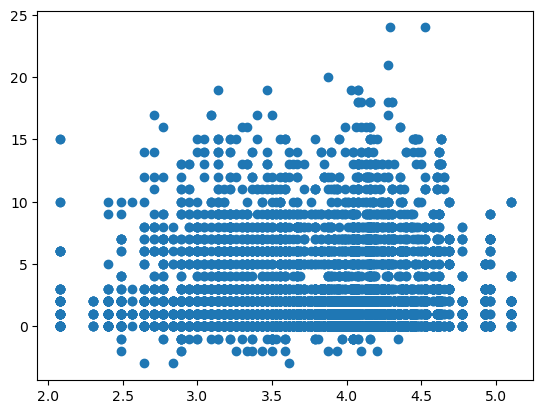

In [6]:

plotdf =depend.query("GW >10 & playtime ==1")
xvalues = np.log(plotdf['Total_Team_points'].values)
yvalues = plotdf['total_points_step']

plt.scatter(x=xvalues, y=yvalues)

# plt.hist(x=(xvalues), bins=20)
# print(min(xvalues))


In [7]:
def total_point_correction(row):
    '''
    To correct issue with -ve points which is not condusive to my model
    '''
    if row <0:
        result = 0
    else:
        result = row
    return result


# depend['total_points'] = depend['total_points'].apply(total_point_correction)
# depend['xP_hat'] = depend['xP'].apply(total_point_correction)       # this is to remove -ve xp values that cause errors in our inference.


depend = (depend
.assign(
    total_points =depend.total_points.apply(total_point_correction),
    xP_hat=depend.xP.apply(total_point_correction),
    explain_Points = depend.total_points_step.apply(total_point_correction)
)).query(" playtime ==1")

# explain = depend['total_points_step'].apply(total_point_correction)



In [8]:
print(depend['explain_Points'].describe())
print(depend['explain_Points'].std())


count    11812.000000
mean         2.589739
std          3.039879
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         24.000000
Name: explain_Points, dtype: float64
3.03987938631422


In [10]:
print(depend['xP_hat'].min())


with py.Model() as TotalPointsModel:

    #define priors as weekly 
    intercept = py.Normal("intercept", mu=0, sigma=1)
    # value = py.Normal("value", mu= 50,sigma=20)            #based on a quick spot check of graphs.ipynb domain is positive
    # transfers_out = py.Normal("transfers_out", mu= 3,sigma=10)
    # transfers_in = py.Normal("transfers_in", mu= 3,sigma=10)

    # lets work on a player position count
    defender    = py.Normal("defender", mu=0, sigma=1) #py.HalfNormal("defender",  sigma=5)# py.Normal("defender",mu=0, sigma=5)
    midfield    = py.Normal("midfield", mu=0, sigma=1)#py.HalfNormal("midfield",  sigma=5) #py.Normal("midfield",mu=0, sigma=5)
    forward     = py.Normal("forward", mu=0, sigma=1)#py.HalfNormal("forward",  sigma=5)

    # try an hierachichal approach
    playtime    = py.Normal("playtime", mu=0, sigma=1)#py.HalfNormal("playtime",  sigma=5) #need to smart about this, there is increasing risk out causing our theta to be -ve causing our model to fail with every inital step when we are drawing our samples.

    #was_home = py.HalfNormal("was_home",  sigma=5)
    #was home indicator 
    xP    = py.Normal("xP", mu=0, sigma=1)# py.LogNormal("xP", mu=0, sigma=1)

    # points current points
    points = py.Normal("points", mu=0, sigma=1)#py.LogNormal("points",mu= 0,sigma=1)

    Total_Team_points = py.Normal("Total_Team_points", mu=0, sigma=1)#py.LogNormal("Total_Team_points",mu= 0,sigma=1)


    # our linear model 
    # theta = b0 +b1 * T1['value'] + b2 *T1['transfers_out'] + b3 *T1['transfers_in']
    position =py.Deterministic('position',
                        defender * depend['ind_DEF'].values                        
                        + midfield * depend['ind_MID'].values 
                        + forward * depend['ind_FWD'].values  
                        )
    

    theta = py.Deterministic('theta'
                        ,(intercept +position
                        + points * (depend['total_points'].values )
                        + xP * depend['xP_hat'].values  
                        + playtime * (depend['playtime'].values)
                        + Total_Team_points* (depend['Total_Team_points'].values)
                        )
                        )
    

    # define poisson likelihood
    y = py.Poisson("y", mu=(theta),observed = (depend.explain_Points.values))  # one step ahead dependency forward py.math.log(theta),, observed = (depend.explain_Points.values)
    

0.0


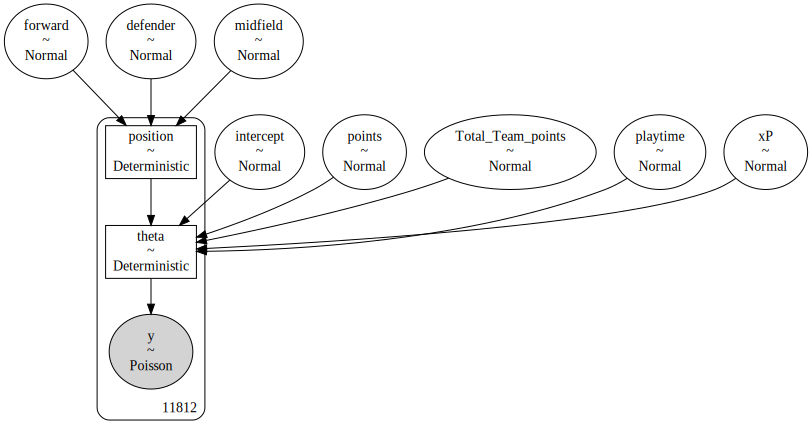

In [64]:
py.model_to_graphviz(TotalPointsModel)

In [65]:

TotalPointsModel.point_logps()
# TotalPointsModel.compile_logp()
# TotalPointsModel.initial_point()
# TotalPointsModel.check_start_vals()

# dir(TotalPointsModel)|
# TotalPointsModel.defender*depend['ind_DEF'].values.min()
# depend['total_points'].values.min()
# y

{'intercept': -0.92,
 'defender': -0.92,
 'midfield': -0.92,
 'forward': -0.92,
 'playtime': -0.92,
 'xP': -0.92,
 'points': -0.92,
 'Total_Team_points': -0.92,
 'y': -inf}

In [66]:
random_seed =500
with TotalPointsModel:
    thetaSample = py.sample(2000,cores=2, chains=1, random_seed=random_seed) 
    
az.plot_trace(thetaSample)


  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'intercept': array(0.73325214), 'defender': array(0.75477598), 'midfield': array(0.52923593), 'forward': array(-0.48179618), 'playtime': array(0.40738098), 'xP': array(0.77141344), 'points': array(0.89076517), 'Total_Team_points': array(-0.8199563)}

Initial evaluation results:
{'intercept': -1.19, 'defender': -1.2, 'midfield': -1.06, 'forward': -1.04, 'playtime': -1.0, 'xP': -1.22, 'points': -1.32, 'Total_Team_points': -1.26, 'y': -inf}

In [41]:
thetaSample.posterior # plotting this 

<xarray.Dataset>
Dimensions:            (chain: 1, draw: 2000, position_dim_0: 108,
                        theta_dim_0: 108)
Coordinates:
  * chain              (chain) int64 0
  * draw               (draw) int64 0 1 2 3 4 5 ... 1995 1996 1997 1998 1999
  * position_dim_0     (position_dim_0) int64 0 1 2 3 4 ... 103 104 105 106 107
  * theta_dim_0        (theta_dim_0) int64 0 1 2 3 4 5 ... 103 104 105 106 107
Data variables:
    intercept          (chain, draw) float64 2.052 1.614 -0.024 ... 1.331 0.8358
    defender           (chain, draw) float64 0.3507 0.5624 ... 0.3572 0.2057
    midfield           (chain, draw) float64 0.09765 0.565 ... 0.3835 0.2969
    forward            (chain, draw) float64 0.5148 0.4474 ... 0.6388 0.8107
    playtime           (chain, draw) float64 -0.01829 0.4029 ... 0.5783 -0.2346
    xP                 (chain, draw) float64 0.3643 0.2909 ... 0.2306 0.2118
    points             (chain, draw) float64 0.2337 0.1641 ... 0.2011 0.2946
    Total_Team_points  (chain, draw) float64 -0.03785 -0.03329 ... 0.002204
    position           (chain, draw, position_dim_0) float64 0.3507 ... 0.2969
    theta              (chain, draw, theta_dim_0) float64 1.608 2.384 ... 2.146
Attributes:
    created_at:                 2022-08-21T20:16:30.947886
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.1.4
    sampling_time:              15.524842977523804
    tuning_steps:               1000

In [59]:
(az.summary(thetaSample))

#So clearly the     

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.458,0.702,0.131,2.767,0.019,0.014,1410.0,1376.0,NaN
defender,-0.487,0.262,-0.947,0.042,0.007,0.006,1242.0,1480.0,NaN
midfield,-0.250,0.257,-0.716,0.261,0.007,0.006,1203.0,1195.0,NaN
forward,-0.263,0.295,-0.826,0.266,0.008,0.006,1332.0,1168.0,NaN
playtime,1.416,0.703,0.084,2.703,0.019,0.013,1438.0,1353.0,NaN
...,...,...,...,...,...,...,...,...,...
theta[509],2.449,0.134,2.187,2.682,0.003,0.002,1753.0,1813.0,NaN
theta[510],2.449,0.134,2.187,2.682,0.003,0.002,1753.0,1813.0,NaN
theta[511],2.440,0.131,2.171,2.665,0.003,0.002,2049.0,1734.0,NaN
theta[512],2.408,0.181,2.079,2.743,0.005,0.003,1339.0,1407.0,NaN


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

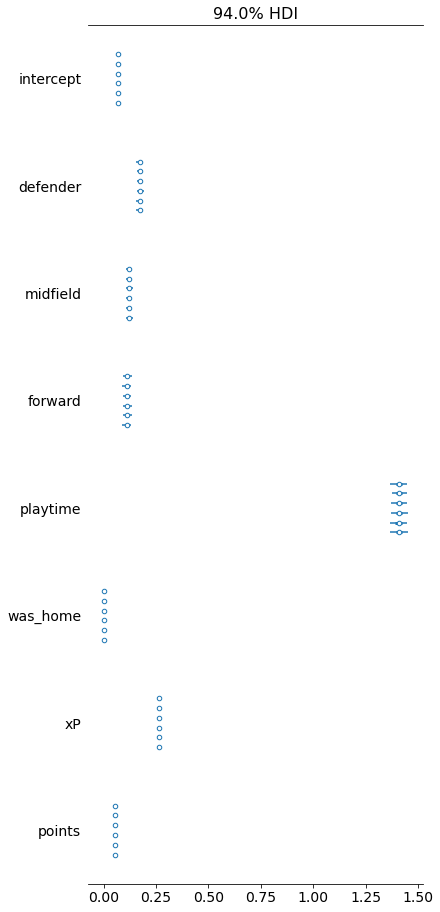

In [59]:
az.plot_forest(thetaSample)